# An NLP, PCA, and Clustering workshop

While there exist a wealth of elaborate and abstract NLP techniques, clustering, dimensionality reduction, and classification should always be in our toolkit as the first techniques to use when dealing with this kind of data.



## Our Dataset: Disasters on social media
Contributors looked at over 10,000 tweets retrieved with a variety of searches like “ablaze”, “quarantine”, and “pandemonium”, then noted whether the tweet referred to a disaster event (as opposed to a joke with the word or a movie review or something non-disastrous).

### Why it matters
We will try to correctly predict tweets that are about disasters. This is a very relevant problem, because:
- It is actionable to anybody trying to get signal from noise (such as police departments in this case)
- It is tricky because relying on keywords is harder than in most cases like spam

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import nltk
import re

import sklearn
from sklearn.metrics import confusion_matrix

np.set_printoptions(suppress=True)  # suppress scientific notation

## Load the data

These tweets have been preprocessed such that the '#' characters have been removed, but the words after the '#' sign remain because they might be relevant (e.g., #disaster).

In [3]:
df_questions = pd.read_csv("social_media_clean_text.csv")
df_questions.columns=['text', 'choose_one', 'class_label']
print(df_questions.shape)
df_questions.head()

(9282, 3)


,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [4]:
df_questions.tail()

,text,choose_one,class_label
9277,the out of control wild fires in california ...,Relevant,1
9278,police investigating after an e bike collided ...,Relevant,1
9279,the latest more homes razed by northern calif...,Relevant,1
9280,meg issues hazardous weather outlook (hwo),Relevant,1
9281,cityofcalgary has activated its municipal eme...,Relevant,1


In [5]:
df_questions.describe().T

,count,mean,std,min,25%,50%,75%,max
class_label,9282.0,0.419953,0.49619,0.0,0.0,0.0,1.0,2.0


## Clean the data

### Standardize the text

While the data looks solid, let's use a few regular expressions to clean up our data, and save it back to disk for future use.

- We don't really need urls
- We would like to have our words all lowercase \(Hello, HELLO, HeLLo, and hello are are all the same for our task\)
- Make sure our tweets only have characters we want.  We remove '\#' characters but keep the words after the '\#' sign because they might be relevant \(eg: #disaster\)
- Remove special characters from the text that are not alphanumeric, parentheses, or punctuation
- Replace "@" symbols with the string "at"



In [7]:
def standardize_text(df, text_field):
    # Remove URLs from the text.  Replace any substrings that match the regular expression pattern http\S+ with an empty 
    # string "".  This pattern matches any URLs (starting with "http" followed by non-whitespace characters)
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    # Remove any remaining instances of the substring "http" from the column
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    # Remove substrings that match the pattern @\S+, which represents sequences starting with "@" followed by non-whitespace 
    # characters. This pattern is commonly used to remove Twitter handles or email addresses
    df[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    # Remove any special characters from the text (i.e., replace any characters that do not match the specified pattern with a 
    # space " ". The pattern [^A-Za-z0-9(),!?@\'\"_\n]` matches any characters that are not alphanumeric, parentheses, commas, 
    # exclamation marks, question marks, at signs, single or double quotes, underscores, or newline characters)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    # Replace "@" symbols with the string "at". It's commonly used to anonymize or normalize email addresses
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df_questions = standardize_text(df_questions, "text")

df_questions.to_csv("clean_data.csv", index=False)
df_questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [8]:
df_clean_questions = pd.read_csv("clean_data.csv")
print(df_clean_questions.shape)
df_clean_questions.tail()

(9282, 3)


,text,choose_one,class_label
9277,the out of control wild fires in california ...,Relevant,1
9278,police investigating after an e bike collided ...,Relevant,1
9279,the latest more homes razed by northern calif...,Relevant,1
9280,meg issues hazardous weather outlook (hwo),Relevant,1
9281,cityofcalgary has activated its municipal eme...,Relevant,1


### Data Overview

Let's look at our class balance.

In [9]:
df_clean_questions.groupby("class_label").count()

,text,choose_one
class_label,,
0,5396,5396
1,3874,3874
2,12,12


In [10]:
df_clean_questions.choose_one.value_counts()

choose_one
Not Relevant    5396
Relevant        3874
Can't Decide      12
Name: count, dtype: int64

We can see our classes are pretty balanced, with a slight oversampling of the "Irrelevant" class.

## Prepare the data

Now that our data is clean, it needs to be prepared.  Let's transform our inputs in a way our model can understand. This implies:
- Tokenizing sentences to a list of separate words
- Creating a train test split
- Inspecting our data a little more to validate results

In [11]:
from nltk.tokenize import RegexpTokenizer

# Split the text into tokens based on sequences of one or more alphanumeric characters, effectively ignoring any punctuation 
# or special characters.  \w in the regular expression matches any alphanumeric character (equivalent to [a-zA-Z0-9_]), and 
# the + quantifier means one or more occurrences of the preceding pattern
tokenizer = RegexpTokenizer(r'\w+')

df_clean_questions["tokens"] = df_clean_questions["text"].apply(tokenizer.tokenize)
df_clean_questions.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


## Analyze the data

### Enter embeddings
 Machine Learning on images can use raw pixels as inputs. Fraud detection algorithms can use customer features. What can NLP use?
 
A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.

The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

### Bag of Words Counts

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

def train_count_vect(X_train):
    vect = CountVectorizer()
    train_dtm = vect.fit_transform(X_train)
    return train_dtm, vect

X = df_clean_questions["text"].tolist()         # corpus
y = df_clean_questions["class_label"].tolist()  # target/labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20240208)

X_train_counts, count_vectorizer = train_count_vect(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the embeddings
Now that we've created embeddings, let's visualize them and see if we can identify some structure. In a perfect world, our embeddings would be so distinct that are two classes would be perfectly separated. Since visualizing data in 20k dimensions is hard, let's project it down to 2.

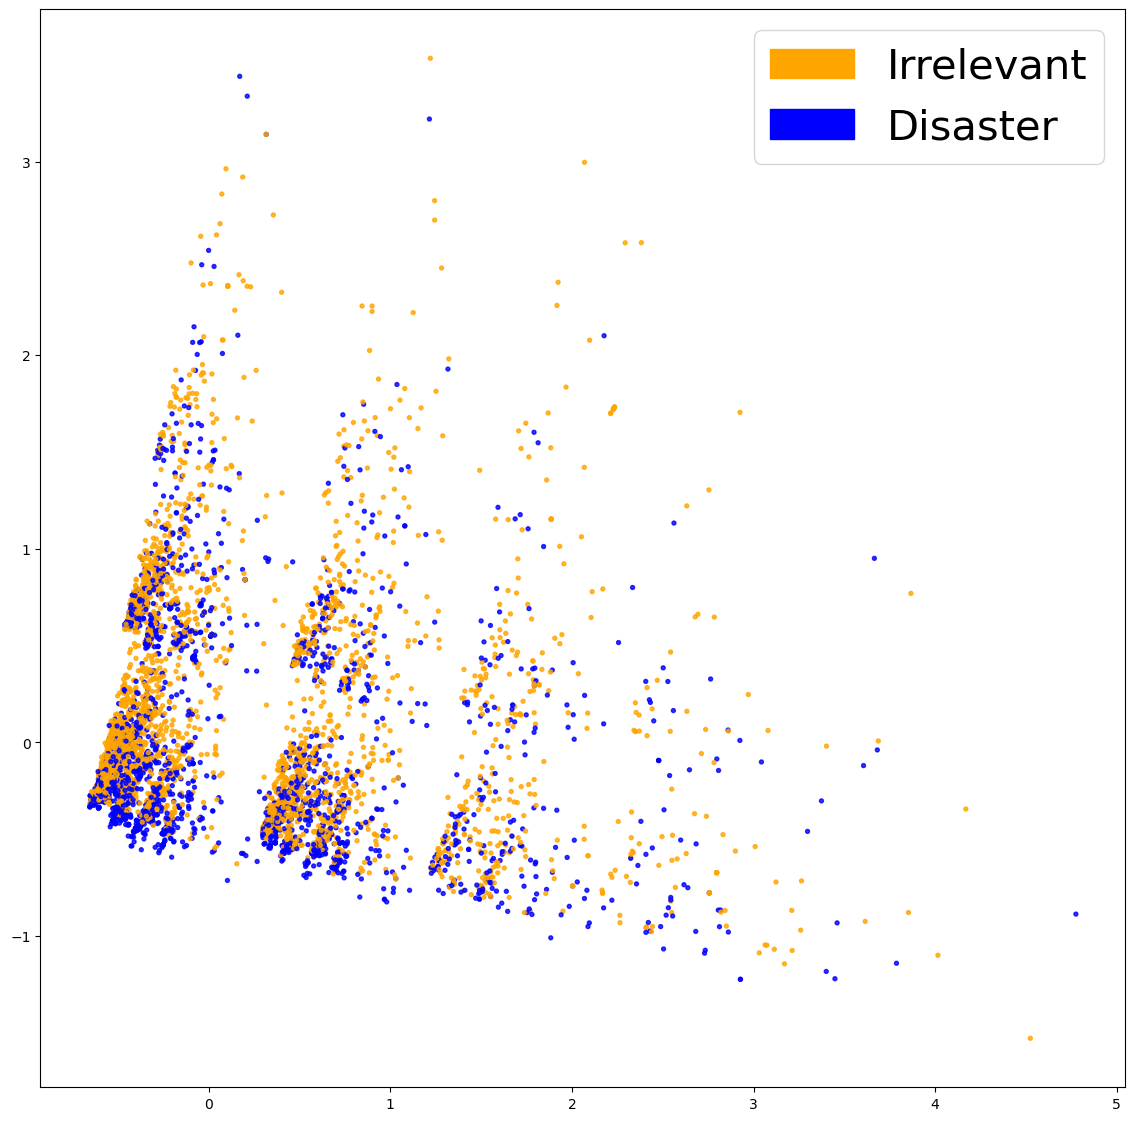

In [13]:
from sklearn.decomposition import PCA, TruncatedSVD

def plot_pca(X, y, savepath="PCA_demo.csv", pca=True):
    if pca:
        X_dense = X.toarray()  # convert the sparse matrix to a dense numpy array.  PCA requires dense data
        pca = PCA(n_components=2, random_state=20240208).fit(X_dense)
        processed_tweets = pca.transform(X_dense)
    else:
        lsa = TruncatedSVD(n_components=2, random_state=20240208).fit(X)
        processed_tweets = lsa.transform(X)
        
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ['orange','blue','blue']

    # Slice processed_tweets to get the first two components from each eigenvector; the xy of each coordinate
    plt.scatter(
        processed_tweets[:, 0], processed_tweets[:, 1], s=8, alpha=0.8, c=y, cmap=matplotlib.colors.ListedColormap(colors)
    )
    red_patch = mpatches.Patch(color='orange', label='Irrelevant')
    green_patch = mpatches.Patch(color='blue', label='Disaster')
    plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

fig = plt.figure(figsize=(14, 14))          
plot_pca(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. Let's see if we can still fit a useful model on them.

## Machine Learning

Now that our data is clean and prepared, let's dive in to the machine learning part.

### Fit a classifier

Start with a logistic regression model.  It is simple, often gets the job done, and is easy to interpret.

In [14]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(
    C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=20240208
)
lr_clf.fit(X_train_counts, y_train)
y_pred_counts = lr_clf.predict(X_test_counts)

### Evaluation
Let's start by looking at some metrics to see how our classifier performed.

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_pred):  
    # precision = true positives / (true positives+false positives)
    precision = precision_score(y_test, y_pred, pos_label=None, average='weighted', zero_division=0)
    
    # recall = true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_pred, pos_label=None, average='weighted')
    
    # f1 = harmonic mean of precision and recall
    f1 = f1_score(y_test, y_pred, pos_label=None, average='weighted')
    
    # accuracy = true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_counts)
print(f"accuracy = {round(accuracy, 3)}, precision = {round(precision, 3)}, recall = {round(recall, 3)}, f1 = {round(f1, 3)}")

accuracy = 0.739, precision = 0.74, recall = 0.739, f1 = 0.74


### Confusion Matrix

Performance metrics are important, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.

BoW confusion matrix
[[852 232   4]
 [242 521   3]
 [  2   1   0]]


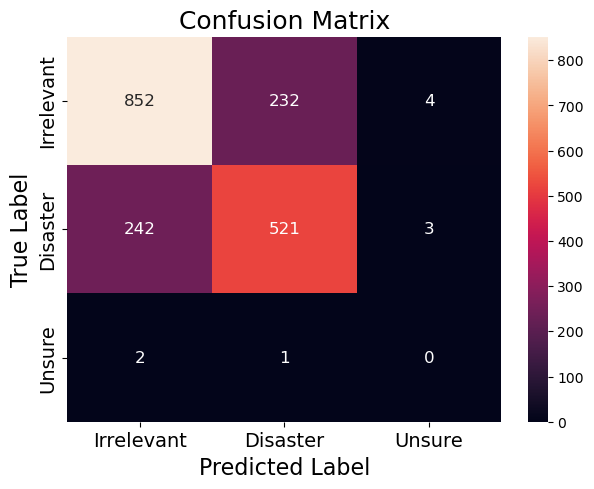

In [16]:
def plot_confusion_matrix(cm):
    classes = ['Irrelevant', 'Disaster', 'Unsure']

    plt.figure(figsize=(7, 5))

    # fmt='d' suppresses scientific notation
    heatmap = sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, annot_kws={"fontsize": 12})
    heatmap.tick_params(axis='both', which='major', labelsize=14)  # increase the fontsize for ticklabels

    # Display the plot
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.title('Confusion Matrix', fontsize=18)
    
cm = confusion_matrix(y_test, y_pred_counts)
print(f"BoW confusion matrix\n{cm}")
plot_confusion_matrix(cm)

Our classifier never predicts class 3, which is not surprising, seeing as it is critically undersampled. This is not very important here, as the label is not very meaningful. Our classifier creates more false negatives than false positives (proportionally). Depending on the use case, this seems desirable (a false positive is quite a high cost for law enforcement for example).

### Feature importance (coefficients) for the logistic regression model

Let's look at the features our classifier is using to make decisions.

In [17]:
def get_most_important_features(vectorizer, model, n=5):
    """
    Extract the most important features (words) from a logistic regression model trained on text data.

    • Iterate over each class in the logistic regression model to extract the most important features (words) for each class.
    • For each class, retrieve the coefficients (importance) of each feature from the logistic regression model and map them 
      back to the corresponding words using the vocabulary generated by the CountVectorizer.
    • Sort the coefficients and retrieve the top n and bottom n features based on their importance.
    • Return a dictionary containing the top and bottom features for each class.
    """
    # Create a dictionary to map indices to words in the vocabulary generated by the CountVectorizer
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # Initialize a dictionary to store the most important features for each class
    classes = {}
    
    # Loop through each class in the logistic regression model
    for class_index in range(model.coef_.shape[0]):
        # Retrieve the coefficients (importance) of each feature for the current class
        word_importances = [(el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])]
        
        # Sort the coefficients based on their importance in descending order       
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        
        # Retrieve the top n and bottom n features based on their importance
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        
        # Store the top and bottom features for the current class in the dictionary
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
        
    return classes

importance = get_most_important_features(count_vectorizer, lr_clf, 10)

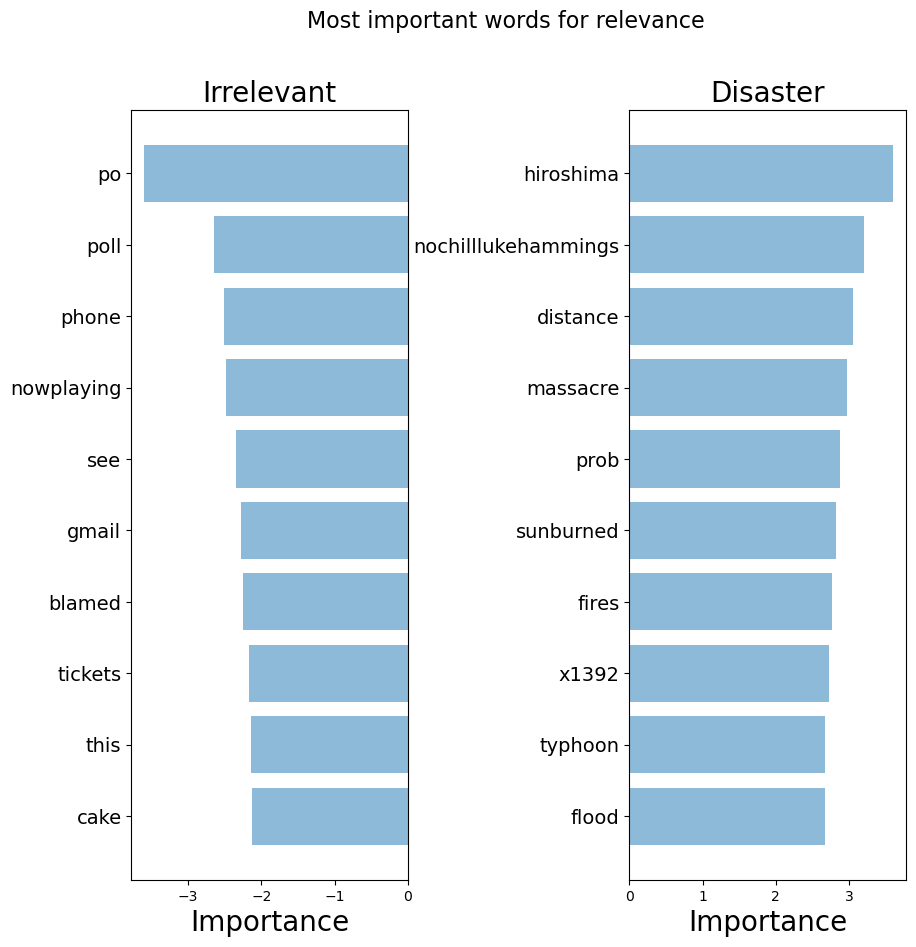

In [18]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    """
    Plot the most important words for each class (Irrelevant and Disaster).  Sort the words and their corresponding scores 
    based on their importance, and then plot them as horizontal bar charts with the words on the y-axis and their importance 
    on the x-axis.
    """
    # Create an array of indices for the words
    y_pos = np.arange(len(top_words))
    
    # Sort the top_words and top_scores based on the top_scores
    top_pairs = [(a, b) for a, b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    # Sort the bottom_words and bottom_scores based on the bottom_scores in reverse order
    bottom_pairs = [(a, b) for a, b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    # Extract the top_words and top_scores from sorted pairs
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    # Extract the bottom_words and bottom_scores from sorted pairs
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    # Plot the bottom_scores and bottom_words
    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    # Plot the top_scores and top_words
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)  # adjust the space between subplots
    plt.show()

# Extract top and bottom scores and words from the importance dictionary
top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Our classifier correctly picks up on some patterns indicative of a disaster, but clearly seems to be overfitting on some irrelevant terms.

## TFIDF Bag of Words

Let's try a slightly more subtle approach. On top of our bag of words model, we use a TF-IDF (Term Frequency, Inverse Document Frequency) which weighs words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.

In [19]:
def tfidf(X_train):
    tfidf_vectorizer = TfidfVectorizer()
    train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    return train_tfidf, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

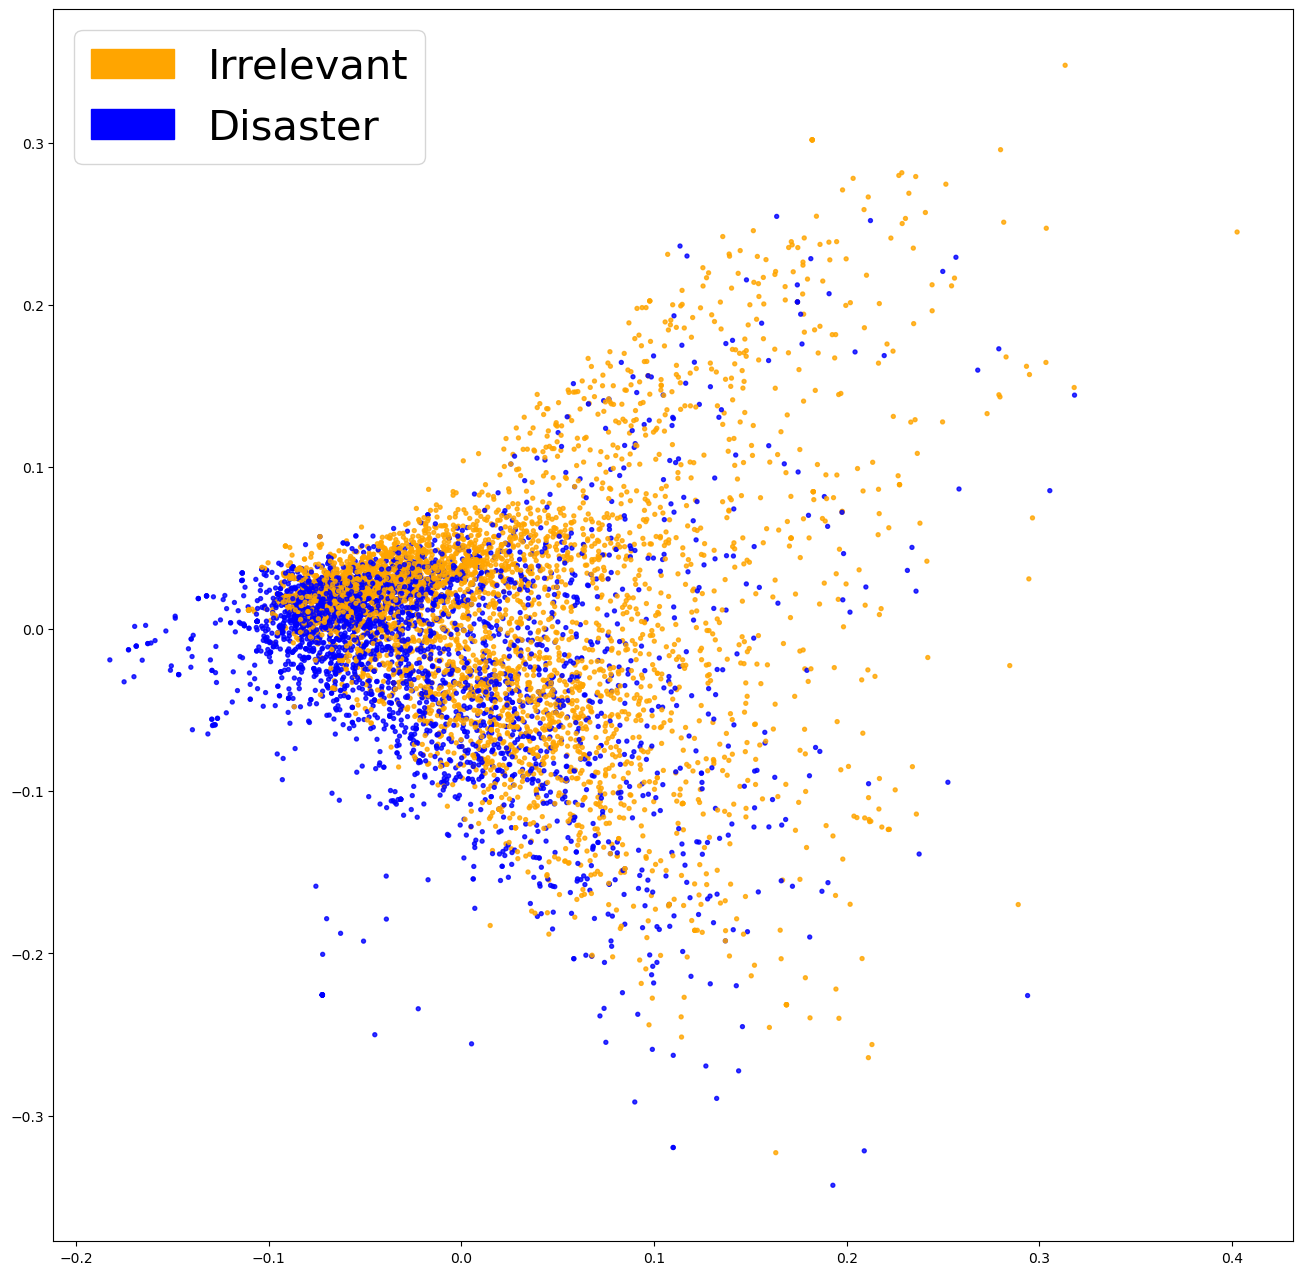

In [20]:
fig = plt.figure(figsize=(16, 16))          
plot_pca(X_train_tfidf, y_train)
plt.show()

These embeddings look much more separated, let's see if it leads to better performance.

In [21]:
lr_clf = LogisticRegression(
    C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=20240208
)
lr_clf.fit(X_train_tfidf, y_train)

y_pred_tfidf = lr_clf.predict(X_test_tfidf)

In [22]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_tfidf)
print(f"accuracy = {round(accuracy, 3)}, precision = {round(precision, 3)}, recall = {round(recall, 3)}, f1 = {round(f1, 3)}")

accuracy = 0.747, precision = 0.746, recall = 0.747, f1 = 0.746


The results are a little better, let's see if they translate to an actual difference in our use case.

TFIDF confusion matrix
[[853 235   0]
 [232 534   0]
 [  3   0   0]]
BoW confusion matrix
[[852 232   4]
 [242 521   3]
 [  2   1   0]]


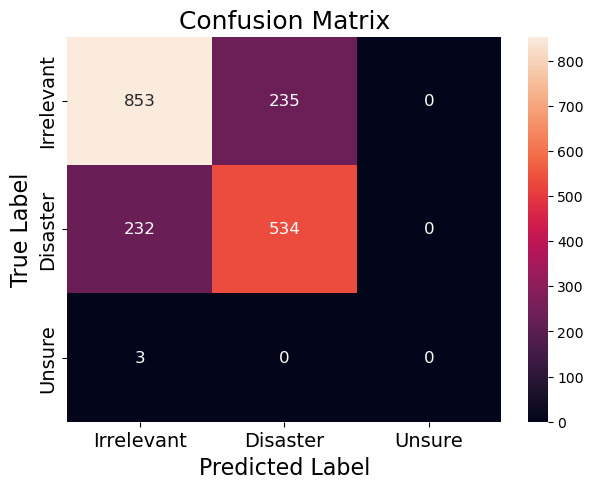

In [23]:
cm2 = confusion_matrix(y_test, y_pred_tfidf)
print(f"TFIDF confusion matrix\n{cm2}")
print(f"BoW confusion matrix\n{cm}")
plot_confusion_matrix(cm2)

Our False positives have decreased, as this model is more conservative about choosing the positive class.

### Feature importance (coefficients) for the logistic regression model

Let's look at the features our classifier is using to make decisions.

In [24]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, lr_clf, 10)

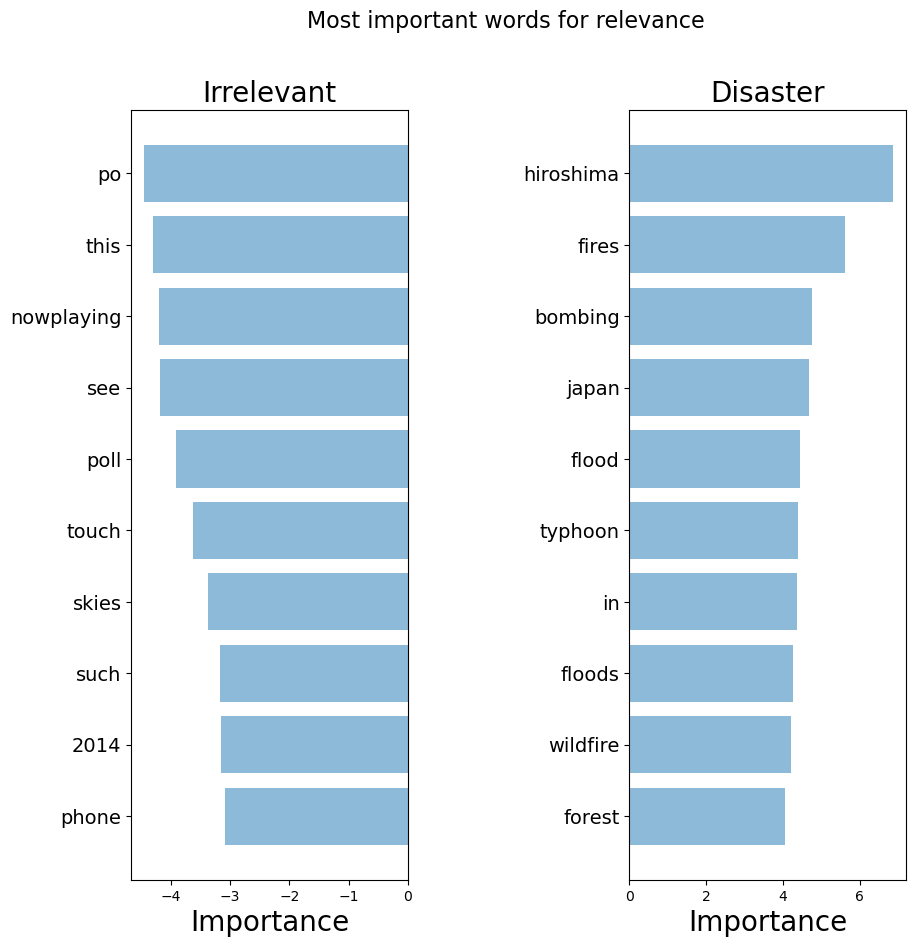

In [25]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

The words it picked up look much more relevant! Although our metrics on our held out validation set haven't increased much, we have much more confidence in the terms our model is using, and thus would feel more comfortable deploying it in a system that would interact with customers.

## Clustering

Clustering is an unsupervised learning method where you are typically using unlabeled data. The clustering algorithm partitions the data in to K clusters, to group similar data in, which, if they were labeled could be done easily.

Since we are using unlabeled data, cluster analysis does not require the data to be split into training and test data; you cannot train on unlabeled data. Train-test splitting is used to avoid overfitting, but if you are not learning labels, you cannot overfit. Cluster analysis is a knowledge discovery method, where you want to discover some new structure in your data, not rediscover something that is already labeled.

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster_kmeans(X, dim_reduction, n_components, n_clusters):
    # Initialize the clusterer with a random generator seed of 20240208 for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, random_state=20240208, n_init='auto')  # ADDED n_init
    print(f"Running K-means clustering algorithm on {len(X)} tweets")
    cluster_labels = []
    processed_tweets = np.ndarray

    if dim_reduction == 'PCA':
        # TfIdfVectorizer.fit_transform() returns a sparse matrix.  However, PCA does not support sparse input. 
        # That matrix has a todense() method, which converts a sparse matrix into a numpy matrix
        X_train_tfidf_dense = np.asarray(X_train_tfidf.todense())  # ADDED conversion to np.matrix, and then passed parameter to fit and transform, below
        pca = PCA(n_components=n_components, random_state=20240208).fit(X_train_tfidf_dense)
        processed_tweets=pca.transform(X_train_tfidf_dense)
    else:
        lsa = TruncatedSVD(n_components=n_components, random_state=20240208).fit(X_train_tfidf)
        processed_tweets = lsa.transform(X_train_tfidf)

    print(f"processed_tweets:  tfidf: {X_train_tfidf.shape}, pca: {processed_tweets.shape}")
    cluster_labels = clusterer.fit_predict(processed_tweets)
    silhouette = round(silhouette_score(processed_tweets, cluster_labels), 6)
    print(f"For n_clusters = {n_clusters}, silhouette_score = {silhouette}, inertia = {clusterer.inertia_}")
    
    return processed_tweets, cluster_labels

## Interactive Scatter Plot

In [27]:
def display_scatter_plot(n_clusters, dim_reduction, processed_tweets, cluster_labels):
    # Generate color dict with a color-blind friendly palette (could also add black, '#000000' or grey, '#999999' to pallette)
    spectral = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#D55E00", "#0072B2",  "#CC79A7"]

    data = list(zip(processed_tweets, cluster_labels.tolist()))
    plt.figure(figsize=(15, 10))

    for i in range(n_clusters):        
        # Assign the pca feature values, x[0] for each point in cluster n, x[2]
        # That is, filter the rows where processed_tweets equals i, the cluster label
        point_slice = np.asarray([x[0] for x in data if x[1] == i])
        
        # Slice point_slice to get the first two components from each eigenvector; the xy of each coordinate
        plt.scatter(point_slice[:, 0], point_slice[:, 1], c=spectral[i], s=50)
        
    return plt.show()

In [28]:
from ipywidgets import widgets, Dropdown
from IPython.display import display
from ipywidgets import interact

@interact(dim_reduction=['PCA', 'LSA'], n_features=[15, 10, 6, 2], n_clusters=range(2, 7))
def display_interactive_scatter_plot(dim_reduction='PCA', n_features=10, n_clusters=6):
    processed_tweets, cluster_labels = cluster_kmeans(X, dim_reduction=dim_reduction, n_components=n_features, n_clusters=n_clusters)
    display_scatter_plot(n_clusters=n_clusters, dim_reduction=dim_reduction, processed_tweets=processed_tweets, cluster_labels=cluster_labels)

interactive(children=(Dropdown(description='dim_reduction', options=('PCA', 'LSA'), value='PCA'), Dropdown(des…

# Takeaways

We now have a solid framework for organizing text data, employing dimensionality reduction techniques, clustering, and training classifiers while efficiently inspecting their results. While we've started to get some interesting results for text generation, we are far from having solved NLP!